## TIES relative binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the TIES application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [2]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [4]:
# input parameters
params = pd.read_csv('./data_ties/ties_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_min = np.min(params, axis=0)
p_max = np.max(params, axis=0)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

In [5]:
print('There are %d inputs' % D)

There are 169 inputs


### Load output samples

Load the corresponding Monte Carlo outputs, in the case the relative binding free energy predictions.

In [6]:
QoI = 'relative_binding_energy'
output = pd.read_csv('./data_ties/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [9]:
average_over_replicas = False

if not average_over_replicas:
    samples = output[:, 2].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Print uncertainty amplification factor

In [10]:
# coefficient of variation of the input, assuming uniform inputs at +/- 15% at the default value
# for all inputs except the temperature, which is at +/- 7.5 %
CV_in = 1 / (D * np.sqrt(3)) * ((D-1) * 0.15 + 0.075)

# coefficient of variation of the output
mean_out = np.mean(samples)
std_out = np.std(samples)
CV_out = std_out / mean_out

# print CV ratio
print('CVR = %.1f' % (np.abs(CV_out) / np.abs(CV_in)))

CVR = 9.5


### Select $d$

This is the dimension of the active subspace.

In [9]:
########################################
# choose the active subspace dimension #
########################################
d = 1

### Hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 4

n_neurons = [d]
for i in range(n_layers-1): n_neurons.append(n_hidden_neurons)

# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        W_1 = das_surrogate.neural_net.layers[1].W
        results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        # results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [15]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 221.56it/s]

 loss = 1.0515


Relative training error = 65.1510 %
Relative test error = 62.9457 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 317.07it/s]

 loss = 1.4695


Relative training error = 62.9107 %
Relative test error = 59.8828 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.44it/s]


 loss = 1.2422
Relative training error = 59.0317 %
Relative test error = 59.0766 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.39it/s]


Relative training error = 54.5610 %
Relative test error = 58.6094 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.25it/s]


Relative training error = 49.4330 %
Relative test error = 58.4912 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.98it/s]


Relative training error = 44.2462 %
Relative test error = 56.7791 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.97it/s]


Relative training error = 40.4535 %
Relative test error = 52.7173 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.82it/s]


 loss = 0.2540
Relative training error = 37.9801 %
Relative test error = 48.4312 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.96it/s]


Relative training error = 35.9419 %
Relative test error = 50.1403 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.15it/s]


Relative training error = 34.2647 %
Relative test error = 45.4938 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3038


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.19it/s]


Relative training error = 32.7117 %
Relative test error = 45.0855 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.23it/s]


Relative training error = 31.2960 %
Relative test error = 42.2474 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1803


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.00it/s]


Relative training error = 29.7620 %
Relative test error = 38.6884 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.93it/s]


Relative training error = 28.6239 %
Relative test error = 36.0033 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.07it/s]


Relative training error = 27.4379 %
Relative test error = 34.3406 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0705


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.47it/s]


Relative training error = 26.7425 %
Relative test error = 32.9491 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.56it/s]


Relative training error = 26.1993 %
Relative test error = 31.0224 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.79it/s]

 loss = 0.1405


Relative training error = 25.4883 %
Relative test error = 30.3415 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.29it/s]

 loss = 0.2383


Relative training error = 24.6998 %
Relative test error = 28.7776 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.71it/s]

 loss = 0.3195


Relative training error = 24.2274 %
Relative test error = 28.0195 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.64it/s]

 loss = 0.0929


Relative training error = 23.4475 %
Relative test error = 28.9182 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.95it/s]


Relative training error = 23.2201 %
Relative test error = 30.5996 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.56it/s]


Relative training error = 22.8429 %
Relative test error = 29.5824 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.72it/s]


Relative training error = 22.3264 %
Relative test error = 29.6093 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.99it/s]


Relative training error = 21.9142 %
Relative test error = 29.8400 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.33it/s]


Relative training error = 21.5378 %
Relative test error = 29.2295 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.65it/s]


Relative training error = 21.3208 %
Relative test error = 29.3837 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.41it/s]


Relative training error = 21.2303 %
Relative test error = 29.4695 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2046


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.20it/s]


Relative training error = 20.8459 %
Relative test error = 29.5958 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 297.61it/s]

Relative training error = 20.8569 %


Relative test error = 29.5034 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.74144717e-03
 -1.77364761e-02  5.10048713e

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.48it/s]


 loss = 3.5518
Relative training error = 65.8236 %
Relative test error = 61.3259 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.48it/s]

 loss = 0.4568


Relative training error = 61.7417 %
Relative test error = 60.5638 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.97it/s]


Relative training error = 57.4870 %
Relative test error = 60.1913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.25it/s]


 loss = 1.5658
Relative training error = 51.0064 %
Relative test error = 60.2003 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.37it/s]


Relative training error = 45.8453 %
Relative test error = 56.4253 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.22it/s]


Relative training error = 40.9964 %
Relative test error = 55.0360 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.72it/s]


Relative training error = 38.0005 %
Relative test error = 51.6728 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.57it/s]


Relative training error = 35.2074 %
Relative test error = 49.5273 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.26it/s]

 loss = 0.2915


Relative training error = 33.0556 %
Relative test error = 47.1790 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.06it/s]

 loss = 0.1082


Relative training error = 31.3646 %
Relative test error = 44.5675 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.24it/s]

 loss = 0.1315


Relative training error = 30.0999 %
Relative test error = 40.2977 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.98it/s]


Relative training error = 29.2056 %
Relative test error = 37.4186 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.22it/s]


Relative training error = 28.0169 %
Relative test error = 36.6403 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.92it/s]

 loss = 0.1069


Relative training error = 26.6524 %
Relative test error = 34.0057 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.39it/s]

 loss = 0.1876


Relative training error = 25.7152 %
Relative test error = 33.0080 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.86it/s]


Relative training error = 25.0172 %
Relative test error = 32.1894 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.67it/s]


Relative training error = 24.4313 %
Relative test error = 32.3484 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.84it/s]


 loss = 0.0971
Relative training error = 23.8227 %
Relative test error = 31.2452 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.91it/s]


Relative training error = 23.1906 %
Relative test error = 31.4105 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2023


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.00it/s]


Relative training error = 22.3929 %
Relative test error = 31.2221 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.39it/s]


Relative training error = 21.9963 %
Relative test error = 30.0825 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.92it/s]


Relative training error = 21.7881 %
Relative test error = 29.3813 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.13it/s]


 loss = 0.0652
Relative training error = 21.4782 %
Relative test error = 29.1977 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.90it/s]


Relative training error = 21.2321 %
Relative test error = 30.3323 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.35it/s]


Relative training error = 21.1209 %
Relative test error = 31.4862 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.14it/s]


 loss = 0.0349
Relative training error = 20.9704 %
Relative test error = 32.4848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.97it/s]

 loss = 0.1327


Relative training error = 20.4942 %
Relative test error = 30.8879 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.7364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.13it/s]


Relative training error = 63.4627 %
Relative test error = 62.5724 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.72it/s]

 loss = 0.5400


Relative training error = 57.4726 %
Relative test error = 58.7615 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.47it/s]

 loss = 0.4382


Relative training error = 48.3119 %
Relative test error = 56.8419 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.20it/s]


Relative training error = 41.3178 %
Relative test error = 54.2030 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.77it/s]


Relative training error = 36.5057 %
Relative test error = 48.5463 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.72it/s]


Relative training error = 33.0191 %
Relative test error = 44.5921 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.42it/s]


Relative training error = 31.0188 %
Relative test error = 43.4031 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.58it/s]

 loss = 0.1524


Relative training error = 28.5285 %
Relative test error = 37.9929 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.62it/s]


Relative training error = 26.8798 %
Relative test error = 34.1630 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.91it/s]


Relative training error = 26.0873 %
Relative test error = 32.4440 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.81it/s]


Relative training error = 25.0458 %
Relative test error = 31.9014 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.96it/s]


Relative training error = 24.0494 %
Relative test error = 32.0577 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.83it/s]

 loss = 0.0916


Relative training error = 23.3730 %
Relative test error = 31.3230 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.28it/s]


Relative training error = 22.8821 %
Relative test error = 31.1886 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.59it/s]


Relative training error = 22.1781 %
Relative test error = 30.1875 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.16it/s]


Relative training error = 21.8353 %
Relative test error = 30.0458 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.33it/s]

 loss = 0.0831


Relative training error = 21.5630 %
Relative test error = 30.7954 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.05it/s]

 loss = 0.1808


Relative training error = 21.0382 %
Relative test error = 30.2404 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.94it/s]

 loss = 0.0565


Relative training error = 20.7660 %
Relative test error = 30.1978 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.22it/s]

 loss = 0.0472


Relative training error = 20.6473 %
Relative test error = 30.3361 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.93it/s]

 loss = 0.0658


Relative training error = 20.4871 %
Relative test error = 29.9531 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.60it/s]

 loss = 0.0918
Relative training error = 20.2357 %


Relative test error = 30.0386 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.16it/s]


Relative training error = 19.9421 %
Relative test error = 30.2726 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.77it/s]


Relative training error = 19.7643 %
Relative test error = 30.0774 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1762


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 544.43it/s]


Relative training error = 19.5267 %
Relative test error = 29.8820 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.64it/s]


Relative training error = 19.3997 %
Relative test error = 29.6392 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.82it/s]


Relative training error = 19.4563 %
Relative test error = 29.6503 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.57it/s]


Relative training error = 19.1368 %
Relative test error = 29.4589 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.54it/s]

 loss = 0.1208


Relative training error = 18.9422 %
Relative test error = 29.8137 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.70it/s]


Relative training error = 18.7666 %
Relative test error = 29.7331 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.39it/s]


Relative training error = 18.5104 %
Relative test error = 30.3505 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 314.54it/s]


Relative training error = 18.4398 %
Relative test error = 30.5839 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.91it/s]


 loss = 0.6525
Relative training error = 60.6414 %
Relative test error = 58.5261 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.38it/s]

 loss = 1.3253


Relative training error = 57.2070 %
Relative test error = 57.8188 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.54it/s]


Relative training error = 53.4211 %
Relative test error = 55.5406 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.45it/s]


Relative training error = 49.7015 %
Relative test error = 54.5753 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.31it/s]


 loss = 0.3424
Relative training error = 45.4706 %
Relative test error = 52.0803 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.90it/s]


Relative training error = 41.6671 %
Relative test error = 50.2786 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.29it/s]


Relative training error = 38.9497 %
Relative test error = 48.7805 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.92it/s]

 loss = 1.2730


Relative training error = 36.5077 %
Relative test error = 46.0470 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.10it/s]


Relative training error = 34.3255 %
Relative test error = 43.8686 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.31it/s]


Relative training error = 33.0295 %
Relative test error = 42.6559 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.27it/s]


Relative training error = 31.5149 %
Relative test error = 40.8409 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1872


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.89it/s]


Relative training error = 29.9839 %
Relative test error = 40.4022 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.51it/s]


Relative training error = 29.0720 %
Relative test error = 39.7214 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1373


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.42it/s]


Relative training error = 27.9716 %
Relative test error = 38.7415 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4599


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.96it/s]


Relative training error = 27.2244 %
Relative test error = 38.5040 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.77it/s]


Relative training error = 26.5068 %
Relative test error = 36.5019 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.24it/s]


Relative training error = 25.8463 %
Relative test error = 34.7405 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.04it/s]

 loss = 0.1016


Relative training error = 25.2144 %
Relative test error = 33.2572 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.81it/s]

 loss = 0.1178


Relative training error = 24.6580 %
Relative test error = 32.3867 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.07it/s]

 loss = 0.1728


Relative training error = 24.1844 %
Relative test error = 31.4708 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.35it/s]


Relative training error = 23.5949 %
Relative test error = 30.3444 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.67it/s]


Relative training error = 23.1060 %
Relative test error = 29.5100 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.68it/s]


 loss = 0.0943
Relative training error = 22.6498 %
Relative test error = 28.8645 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.07it/s]


Relative training error = 22.3045 %
Relative test error = 29.0490 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.95it/s]


Relative training error = 21.8942 %
Relative test error = 29.2300 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.35it/s]


 loss = 0.0724
Relative training error = 21.6944 %
Relative test error = 28.8649 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.25it/s]


Relative training error = 21.4934 %
Relative test error = 29.4019 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.69it/s]


Relative training error = 21.1113 %
Relative test error = 30.2460 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.22it/s]


Relative training error = 20.8306 %
Relative test error = 30.2745 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.94it/s]


Relative training error = 20.7206 %
Relative test error = 29.1368 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6785


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.75it/s]


Relative training error = 62.5647 %
Relative test error = 62.1907 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.77it/s]

 loss = 0.5525


Relative training error = 59.2888 %
Relative test error = 64.0412 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.21it/s]


Relative training error = 55.3982 %
Relative test error = 64.6398 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.20it/s]


 loss = 1.1989
Relative training error = 51.6054 %
Relative test error = 65.7173 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.86it/s]

 loss = 0.4956


Relative training error = 48.0002 %
Relative test error = 63.4195 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.80it/s]


Relative training error = 61.1990 %
Relative test error = 60.1150 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.57it/s]


Relative training error = 56.0901 %
Relative test error = 61.0187 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.81it/s]

 loss = 0.6735


Relative training error = 49.4227 %
Relative test error = 59.5619 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.44it/s]

 loss = 0.6045


Relative training error = 44.1252 %
Relative test error = 57.9633 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.58it/s]


 loss = 0.3137
Relative training error = 40.6672 %
Relative test error = 53.7856 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.04it/s]


Relative training error = 37.8260 %
Relative test error = 51.4420 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5972


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 300.33it/s]


Relative training error = 35.4303 %
Relative test error = 48.9509 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.14it/s]


 loss = 0.2877
Relative training error = 33.3591 %
Relative test error = 45.1565 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.35it/s]


 loss = 0.1662
Relative training error = 31.7649 %
Relative test error = 41.4508 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.28it/s]


Relative training error = 30.3641 %
Relative test error = 39.5184 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.91it/s]


Relative training error = 28.8473 %
Relative test error = 36.6960 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.02it/s]


Relative training error = 28.0312 %
Relative test error = 36.2854 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2517


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.73it/s]


Relative training error = 26.8522 %
Relative test error = 36.9209 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.49it/s]


Relative training error = 25.9362 %
Relative test error = 35.3887 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.26it/s]


Relative training error = 25.3373 %
Relative test error = 33.2732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.75it/s]


Relative training error = 24.2965 %
Relative test error = 31.8976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 524.66it/s]

 loss = 0.0824


Relative training error = 23.4882 %
Relative test error = 31.9967 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.85it/s]

 loss = 0.0842


Relative training error = 22.9490 %
Relative test error = 33.2845 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.10it/s]

 loss = 0.0870


Relative training error = 22.7471 %
Relative test error = 32.3034 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.49it/s]

 loss = 0.2013


Relative training error = 22.3710 %
Relative test error = 32.0850 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.24it/s]

 loss = 0.0921


Relative training error = 21.9804 %
Relative test error = 31.6508 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.86it/s]


Relative training error = 21.5675 %
Relative test error = 31.2426 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0860


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.63it/s]


Relative training error = 21.4155 %
Relative test error = 31.0773 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.09it/s]


Relative training error = 20.9714 %
Relative test error = 31.1364 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.36it/s]


Relative training error = 20.9838 %
Relative test error = 30.8503 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.95it/s]


Relative training error = 20.7274 %
Relative test error = 31.3217 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.18it/s]


Relative training error = 20.4756 %
Relative test error = 32.5380 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1979


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.03it/s]


Relative training error = 20.1498 %
Relative test error = 31.7440 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1430


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.49it/s]


Relative training error = 19.9162 %
Relative test error = 31.5590 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.57it/s]


Relative training error = 19.6386 %
Relative test error = 30.7808 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.67it/s]


Relative training error = 19.5499 %
Relative test error = 30.8978 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.16it/s]


Relative training error = 19.2928 %
Relative test error = 30.7268 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.43it/s]


Relative training error = 19.3658 %
Relative test error = 30.0462 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.73it/s]


Relative training error = 19.0900 %
Relative test error = 30.3691 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.31it/s]

 loss = 0.0750


Relative training error = 18.9537 %
Relative test error = 31.2020 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.59it/s]

 loss = 0.0524


Relative training error = 18.7929 %
Relative test error = 31.4203 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.78it/s]


Relative training error = 18.6212 %
Relative test error = 30.9793 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.09it/s]


Relative training error = 63.2962 %
Relative test error = 61.9670 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.84it/s]

 loss = 0.3609


Relative training error = 61.6852 %
Relative test error = 60.7717 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.63it/s]

 loss = 0.4488
Relative training error = 58.7782 %


Relative test error = 61.0874 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.95it/s]


Relative training error = 54.8381 %
Relative test error = 61.4377 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1050


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.34it/s]


Relative training error = 50.4825 %
Relative test error = 62.2320 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.12it/s]

 loss = 0.4183


Relative training error = 46.3942 %
Relative test error = 62.0314 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.32it/s]


Relative training error = 66.3717 %
Relative test error = 62.0334 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.50it/s]


Relative training error = 62.1235 %
Relative test error = 58.5118 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5721


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.70it/s]


Relative training error = 59.7140 %
Relative test error = 57.2904 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.81it/s]


Relative training error = 54.6855 %
Relative test error = 54.6796 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.74it/s]


Relative training error = 49.0901 %
Relative test error = 54.7310 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.17it/s]


Relative training error = 44.0121 %
Relative test error = 53.2166 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.95it/s]

 loss = 1.2008


Relative training error = 39.5078 %
Relative test error = 50.8692 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.49it/s]


Relative training error = 36.7310 %
Relative test error = 47.5988 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.45it/s]


Relative training error = 34.2874 %
Relative test error = 44.6091 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.06it/s]


Relative training error = 32.1672 %
Relative test error = 41.8870 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.58it/s]


Relative training error = 30.3887 %
Relative test error = 39.4086 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.59it/s]


 loss = 0.1308
Relative training error = 28.5118 %
Relative test error = 37.0772 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.96it/s]


Relative training error = 27.6113 %
Relative test error = 35.0596 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.43it/s]


Relative training error = 27.1094 %
Relative test error = 34.3610 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.28it/s]


 loss = 0.1039
Relative training error = 26.0532 %
Relative test error = 34.0253 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.62it/s]


Relative training error = 25.3400 %
Relative test error = 34.0849 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.15it/s]


Relative training error = 24.9470 %
Relative test error = 33.6471 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.21it/s]


 loss = 0.1226
Relative training error = 24.6515 %
Relative test error = 33.5535 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1071


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.12it/s]


Relative training error = 23.8102 %
Relative test error = 32.6019 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.65it/s]


Relative training error = 23.2088 %
Relative test error = 32.0326 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.04it/s]


Relative training error = 22.7960 %
Relative test error = 31.3118 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.06it/s]


Relative training error = 22.5704 %
Relative test error = 30.9030 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.64it/s]


Relative training error = 22.2633 %
Relative test error = 30.7645 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.13it/s]


Relative training error = 21.8556 %
Relative test error = 31.3609 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.27it/s]


 loss = 0.2030
Relative training error = 21.4945 %
Relative test error = 30.8015 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.07it/s]


 loss = 0.0955
Relative training error = 21.2041 %
Relative test error = 31.0961 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.57it/s]


 loss = 0.0508
Relative training error = 21.1804 %
Relative test error = 30.9281 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.08it/s]


Relative training error = 20.9956 %
Relative test error = 30.6917 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.13it/s]


 loss = 0.2107
Relative training error = 20.7252 %
Relative test error = 30.2291 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.96it/s]


 loss = 0.0654
Relative training error = 20.5970 %
Relative test error = 29.2635 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.53it/s]


Relative training error = 20.5177 %
Relative test error = 30.0180 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0752


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.90it/s]


Relative training error = 20.3951 %
Relative test error = 30.6793 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.58it/s]


Relative training error = 20.1445 %
Relative test error = 31.8783 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.05it/s]


Relative training error = 19.8572 %
Relative test error = 30.8441 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.3049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.74it/s]


Relative training error = 62.9472 %
Relative test error = 59.7724 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.69it/s]

 loss = 0.5140


Relative training error = 59.5565 %
Relative test error = 55.0128 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.81it/s]


Relative training error = 52.2450 %
Relative test error = 54.1613 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.02it/s]


Relative training error = 46.7634 %
Relative test error = 52.7538 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.73it/s]


Relative training error = 42.6415 %
Relative test error = 50.6342 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.81it/s]


Relative training error = 39.3830 %
Relative test error = 48.6421 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 550.63it/s]

 loss = 0.1724


Relative training error = 36.5756 %
Relative test error = 46.9202 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.56it/s]


 loss = 0.1802
Relative training error = 34.7517 %
Relative test error = 44.2909 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1932


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.09it/s]


Relative training error = 32.8033 %
Relative test error = 42.8380 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.72it/s]


Relative training error = 31.1631 %
Relative test error = 40.0085 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1794


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.16it/s]


Relative training error = 29.4378 %
Relative test error = 38.2628 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.41it/s]


Relative training error = 28.1329 %
Relative test error = 37.2413 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.01it/s]


Relative training error = 27.1277 %
Relative test error = 36.0331 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.85it/s]


Relative training error = 26.1068 %
Relative test error = 35.3307 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.71it/s]


 loss = 0.0941
Relative training error = 25.0160 %
Relative test error = 34.2681 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.97it/s]


Relative training error = 24.3491 %
Relative test error = 33.8445 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.69it/s]


Relative training error = 23.6633 %
Relative test error = 33.8717 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.10it/s]

 loss = 0.1077


Relative training error = 23.2783 %
Relative test error = 33.8869 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 301.40it/s]

 loss = 0.1412


Relative training error = 22.6700 %
Relative test error = 33.7839 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.04it/s]

 loss = 0.1137


Relative training error = 22.1641 %
Relative test error = 34.4820 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.21it/s]

 loss = 0.2508


Relative training error = 21.5862 %
Relative test error = 33.8319 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 309.17it/s]

 loss = 0.1123


Relative training error = 21.4234 %
Relative test error = 33.8147 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.26it/s]

 loss = 0.1451


Relative training error = 21.0488 %
Relative test error = 32.7531 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.46it/s]

 loss = 0.0908


Relative training error = 20.8634 %
Relative test error = 32.0261 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.18it/s]


 loss = 0.2578
Relative training error = 20.5064 %
Relative test error = 32.5156 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.56it/s]


 loss = 0.1113
Relative training error = 20.1165 %
Relative test error = 31.4383 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.20it/s]


Relative training error = 19.8338 %
Relative test error = 31.1498 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.62it/s]


Relative training error = 19.5907 %
Relative test error = 31.2276 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0782


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.83it/s]


Relative training error = 19.3605 %
Relative test error = 31.1387 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.01it/s]


Relative training error = 19.3469 %
Relative test error = 31.5499 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.34it/s]

 loss = 0.1405


Relative training error = 19.1335 %
Relative test error = 31.3789 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.11it/s]


Relative training error = 62.7033 %
Relative test error = 61.1646 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.31it/s]


Relative training error = 57.8279 %
Relative test error = 59.5911 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3430


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.05it/s]


Relative training error = 50.9209 %
Relative test error = 61.5635 %


 loss = 0.4460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.67it/s]


Relative training error = 45.6986 %
Relative test error = 61.1936 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.04it/s]


Relative training error = 40.1361 %
Relative test error = 59.8310 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.39it/s]


Relative training error = 35.9000 %
Relative test error = 54.5133 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.97it/s]


Relative training error = 33.4794 %
Relative test error = 51.8824 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.89it/s]


Relative training error = 31.6431 %
Relative test error = 49.2955 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.45it/s]


Relative training error = 30.2075 %
Relative test error = 45.2131 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.58it/s]


Relative training error = 28.8035 %
Relative test error = 43.1979 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.77it/s]


Relative training error = 27.9648 %
Relative test error = 41.7708 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.34it/s]


Relative training error = 26.9657 %
Relative test error = 39.7142 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.18it/s]


Relative training error = 26.1314 %
Relative test error = 38.2475 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.01it/s]


Relative training error = 25.1586 %
Relative test error = 37.3739 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.27it/s]

 loss = 0.0967


Relative training error = 24.5301 %
Relative test error = 35.8773 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.66it/s]

 loss = 0.2292


Relative training error = 23.8054 %
Relative test error = 34.5267 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.86it/s]


Relative training error = 23.0606 %
Relative test error = 33.7527 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.67it/s]


Relative training error = 22.7937 %
Relative test error = 32.5506 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.66it/s]


Relative training error = 22.6825 %
Relative test error = 31.8124 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.90it/s]


Relative training error = 22.5451 %
Relative test error = 31.3976 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.30it/s]


Relative training error = 22.2985 %
Relative test error = 31.3279 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.62it/s]


Relative training error = 22.0624 %
Relative test error = 30.1941 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.87it/s]


Relative training error = 21.6822 %
Relative test error = 29.2985 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.84it/s]


Relative training error = 21.4132 %
Relative test error = 28.9913 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.46it/s]


Relative training error = 21.0431 %
Relative test error = 28.9307 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.22it/s]


Relative training error = 20.8497 %
Relative test error = 28.7000 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.58it/s]


Relative training error = 20.4912 %
Relative test error = 28.0209 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.30it/s]


 loss = 0.0697
Relative training error = 20.2597 %
Relative test error = 27.5897 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.03it/s]


Relative training error = 19.9947 %
Relative test error = 27.8902 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.73it/s]


Relative training error = 19.6995 %
Relative test error = 27.2402 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.42it/s]


Relative training error = 19.5293 %
Relative test error = 28.1823 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.74it/s]


Relative training error = 19.3746 %
Relative test error = 28.3852 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.25it/s]


Relative training error = 19.3505 %
Relative test error = 28.6574 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.44it/s]


Relative training error = 19.1363 %
Relative test error = 27.5373 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.07it/s]


 loss = 0.4768
Relative training error = 60.7179 %
Relative test error = 59.5893 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.39it/s]

 loss = 0.8104


Relative training error = 55.4872 %
Relative test error = 58.4306 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.45it/s]

 loss = 0.7402


Relative training error = 46.4470 %
Relative test error = 56.2733 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.81it/s]


 loss = 0.2368
Relative training error = 41.0193 %
Relative test error = 54.8288 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3426


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.24it/s]


Relative training error = 36.9881 %
Relative test error = 50.2659 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.70it/s]


Relative training error = 34.5691 %
Relative test error = 44.6674 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.64it/s]


Relative training error = 31.9310 %
Relative test error = 40.8749 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.36it/s]


Relative training error = 30.1531 %
Relative test error = 37.2657 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 338.47it/s]


Relative training error = 28.5094 %
Relative test error = 32.5224 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.40it/s]


Relative training error = 27.3820 %
Relative test error = 30.9541 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 543.47it/s]


 loss = 0.1131
Relative training error = 26.1242 %
Relative test error = 30.4340 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.97it/s]


Relative training error = 25.6868 %
Relative test error = 29.2137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.06it/s]


 loss = 0.1801
Relative training error = 24.6816 %
Relative test error = 28.2872 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.85it/s]


Relative training error = 24.0830 %
Relative test error = 27.7574 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.64it/s]


Relative training error = 23.6045 %
Relative test error = 28.1366 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.12it/s]


Relative training error = 22.5828 %
Relative test error = 27.6871 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.36it/s]


Relative training error = 22.0481 %
Relative test error = 28.1071 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.40it/s]


Relative training error = 21.7041 %
Relative test error = 28.3151 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.08it/s]


Relative training error = 21.3215 %
Relative test error = 27.7373 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.73it/s]


Relative training error = 20.8291 %
Relative test error = 28.4622 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.59it/s]


Relative training error = 20.7225 %
Relative test error = 28.4144 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.69it/s]


 loss = 0.0652
Relative training error = 20.6050 %
Relative test error = 29.6631 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.56it/s]


 loss = 0.0499
Relative training error = 20.3642 %
Relative test error = 31.3562 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.98it/s]


Relative training error = 61.5752 %
Relative test error = 62.2460 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.08it/s]

 loss = 0.4464


Relative training error = 57.6849 %
Relative test error = 65.5796 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.12it/s]


 loss = 1.6301
Relative training error = 52.7301 %
Relative test error = 68.5800 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.63it/s]


Relative training error = 47.9436 %
Relative test error = 65.8017 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.78it/s]


Relative training error = 44.4898 %
Relative test error = 63.9548 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.27it/s]


 loss = 0.2527
Relative training error = 41.9255 %
Relative test error = 59.6484 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.88it/s]


Relative training error = 39.8614 %
Relative test error = 56.9010 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.77it/s]


Relative training error = 38.0455 %
Relative test error = 54.3735 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.85it/s]


Relative training error = 36.3137 %
Relative test error = 52.6467 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.51it/s]


 loss = 0.5319
Relative training error = 34.5074 %
Relative test error = 51.4337 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 312.11it/s]

 loss = 0.3954


Relative training error = 33.0380 %
Relative test error = 46.6274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.41it/s]


 loss = 0.1730
Relative training error = 31.4093 %
Relative test error = 42.8433 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.46it/s]


Relative training error = 30.2075 %
Relative test error = 41.5628 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.67it/s]


Relative training error = 29.1119 %
Relative test error = 40.6362 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.28it/s]


Relative training error = 28.1822 %
Relative test error = 38.9784 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.74it/s]


Relative training error = 27.5294 %
Relative test error = 37.8057 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.37it/s]


Relative training error = 26.6457 %
Relative test error = 35.8447 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.14it/s]

 loss = 0.3484
Relative training error = 25.9165 %


Relative test error = 35.2110 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.97it/s]

 loss = 0.5742


Relative training error = 25.1319 %
Relative test error = 33.9578 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0920


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.26it/s]


Relative training error = 24.8201 %
Relative test error = 32.8851 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.46it/s]

 loss = 0.2444


Relative training error = 24.2729 %
Relative test error = 32.6146 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.06it/s]


Relative training error = 23.3571 %
Relative test error = 31.1953 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.55it/s]


Relative training error = 22.9955 %
Relative test error = 30.1693 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.34it/s]


Relative training error = 22.5793 %
Relative test error = 30.1884 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.19it/s]


Relative training error = 22.2377 %
Relative test error = 30.3649 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.11it/s]

 loss = 0.0680
Relative training error = 21.7714 %
Relative test error = 30.6091 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.37it/s]


 loss = 0.2026
Relative training error = 21.4143 %
Relative test error = 31.3112 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.06it/s]


 loss = 2.1716
Relative training error = 62.9263 %
Relative test error = 60.0533 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.24it/s]

 loss = 1.5300


Relative training error = 54.7061 %
Relative test error = 56.4975 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.63it/s]


Relative training error = 45.3361 %
Relative test error = 51.9691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.75it/s]


Relative training error = 39.8032 %
Relative test error = 47.6497 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.78it/s]


 loss = 0.2736
Relative training error = 36.1794 %
Relative test error = 45.5746 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2760


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.05it/s]


Relative training error = 33.8842 %
Relative test error = 43.0413 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.43it/s]


Relative training error = 32.1241 %
Relative test error = 39.1946 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.40it/s]


 loss = 0.1581
Relative training error = 30.4666 %
Relative test error = 37.7215 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5040


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.72it/s]


Relative training error = 29.2365 %
Relative test error = 33.7647 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.45it/s]


Relative training error = 27.6234 %
Relative test error = 32.0448 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.23it/s]


Relative training error = 26.9021 %
Relative test error = 30.7564 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.44it/s]


Relative training error = 25.8840 %
Relative test error = 30.6665 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.23it/s]


 loss = 0.0981
Relative training error = 25.2921 %
Relative test error = 28.6238 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.95it/s]


 loss = 0.1604
Relative training error = 24.3249 %
Relative test error = 27.9386 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.50it/s]


Relative training error = 23.7974 %
Relative test error = 28.2051 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.12it/s]


 loss = 0.5082
Relative training error = 23.3811 %
Relative test error = 27.8482 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.69it/s]


 loss = 0.2968
Relative training error = 22.7862 %
Relative test error = 27.3604 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.25it/s]


Relative training error = 22.5148 %
Relative test error = 26.8301 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.44it/s]


Relative training error = 22.1176 %
Relative test error = 27.0180 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.11it/s]


Relative training error = 22.0400 %
Relative test error = 26.8084 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.11it/s]


Relative training error = 21.3605 %
Relative test error = 27.2995 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.15it/s]


 loss = 0.0460
Relative training error = 21.1735 %
Relative test error = 28.7309 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.85it/s]


 loss = 0.3368
Relative training error = 20.6664 %
Relative test error = 28.5544 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.79it/s]


Relative training error = 20.5801 %
Relative test error = 27.0607 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.81it/s]


Relative training error = 20.4122 %
Relative test error = 26.9049 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.87it/s]


Relative training error = 20.0982 %
Relative test error = 27.4350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.60it/s]


Relative training error = 20.1375 %
Relative test error = 29.0923 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.29it/s]


Relative training error = 20.0016 %
Relative test error = 28.3602 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.35it/s]


Relative training error = 19.8008 %
Relative test error = 29.6112 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.46it/s]


Relative training error = 19.3205 %
Relative test error = 28.9146 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.81it/s]


Relative training error = 19.5941 %
Relative test error = 29.2907 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1427


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.30it/s]


Relative training error = 19.2148 %
Relative test error = 28.3189 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.70it/s]


Relative training error = 19.3413 %
Relative test error = 27.4924 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.38it/s]


Relative training error = 19.2309 %
Relative test error = 27.0778 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.92it/s]


Relative training error = 18.9640 %
Relative test error = 27.4666 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.41it/s]


Relative training error = 18.9142 %
Relative test error = 27.8914 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.26it/s]


Relative training error = 18.7561 %
Relative test error = 27.9925 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.97it/s]


Relative training error = 18.8716 %
Relative test error = 28.5318 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.49it/s]


 loss = 1.0444
Relative training error = 62.8822 %
Relative test error = 60.8424 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.2382


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.30it/s]


Relative training error = 55.6548 %
Relative test error = 54.5222 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.88it/s]

 loss = 0.6586


Relative training error = 48.6966 %
Relative test error = 52.0811 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.68it/s]


 loss = 0.6618
Relative training error = 43.4130 %
Relative test error = 50.5267 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.03it/s]


Relative training error = 39.4164 %
Relative test error = 47.0135 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.19it/s]


Relative training error = 36.5372 %
Relative test error = 45.5569 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.41it/s]


Relative training error = 34.6237 %
Relative test error = 43.0758 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.88it/s]


Relative training error = 32.3084 %
Relative test error = 40.9830 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.94it/s]


Relative training error = 31.4956 %
Relative test error = 38.5476 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.34it/s]


Relative training error = 30.2327 %
Relative test error = 36.4106 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.64it/s]


 loss = 0.1325
Relative training error = 28.9941 %
Relative test error = 34.7663 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.39it/s]


Relative training error = 28.0399 %
Relative test error = 33.4610 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1270


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.87it/s]


Relative training error = 27.3844 %
Relative test error = 32.3674 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.37it/s]


Relative training error = 27.0930 %
Relative test error = 32.1067 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.89it/s]


Relative training error = 26.2833 %
Relative test error = 31.2835 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.94it/s]


Relative training error = 25.5647 %
Relative test error = 31.4154 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.61it/s]


Relative training error = 25.0108 %
Relative test error = 31.0664 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.29it/s]


 loss = 0.0513
Relative training error = 24.3651 %
Relative test error = 30.8728 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.22it/s]


Relative training error = 23.8048 %
Relative test error = 30.0163 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.68it/s]

 loss = 0.0789


Relative training error = 23.4287 %
Relative test error = 29.7324 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.05it/s]


 loss = 0.0971
Relative training error = 23.0085 %
Relative test error = 30.1555 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.35it/s]

 loss = 0.1014


Relative training error = 22.6149 %
Relative test error = 30.5666 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.28it/s]


Relative training error = 22.0502 %
Relative test error = 30.1654 %


 loss = 0.1202


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.50it/s]


Relative training error = 21.7368 %
Relative test error = 30.6475 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.69it/s]


Relative training error = 21.4765 %
Relative test error = 30.3924 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 281.51it/s]

 loss = 0.0873


Relative training error = 21.3582 %
Relative test error = 29.6783 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.12it/s]


 loss = 0.0741
Relative training error = 21.3463 %
Relative test error = 29.3580 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1068


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.26it/s]


Relative training error = 20.9382 %
Relative test error = 29.7089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.69it/s]


Relative training error = 20.7962 %
Relative test error = 29.7185 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.07it/s]


Relative training error = 20.5535 %
Relative test error = 30.0608 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.27it/s]


 loss = 0.1535
Relative training error = 20.3987 %
Relative test error = 30.9465 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.76it/s]


 loss = 1.5031
Relative training error = 64.3459 %
Relative test error = 60.2721 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.11it/s]

 loss = 0.5900


Relative training error = 62.6312 %
Relative test error = 61.9053 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.01it/s]


Relative training error = 59.0883 %
Relative test error = 58.9773 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.25it/s]


 loss = 0.7330
Relative training error = 56.2109 %
Relative test error = 58.8199 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.43it/s]


 loss = 0.5841
Relative training error = 53.1180 %
Relative test error = 57.9771 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.82it/s]


Relative training error = 49.2433 %
Relative test error = 57.7740 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.71it/s]


Relative training error = 46.0372 %
Relative test error = 56.4343 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.73it/s]


Relative training error = 43.1135 %
Relative test error = 53.7896 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.47it/s]


 loss = 0.3480
Relative training error = 40.5176 %
Relative test error = 50.5209 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.69it/s]


Relative training error = 38.1674 %
Relative test error = 47.9420 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.27it/s]


Relative training error = 36.2014 %
Relative test error = 47.7950 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.53it/s]


Relative training error = 34.6551 %
Relative test error = 45.7333 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.04it/s]


Relative training error = 32.6450 %
Relative test error = 42.1093 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.88it/s]


Relative training error = 30.5407 %
Relative test error = 39.2545 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.74it/s]


Relative training error = 29.3028 %
Relative test error = 37.9931 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1018


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.62it/s]


Relative training error = 27.8789 %
Relative test error = 35.9784 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.77it/s]


Relative training error = 27.0000 %
Relative test error = 34.0187 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.39it/s]

 loss = 0.0817


Relative training error = 26.2202 %
Relative test error = 32.9859 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.32it/s]


Relative training error = 25.2578 %
Relative test error = 32.9098 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0889


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.83it/s]


Relative training error = 24.7588 %
Relative test error = 32.2460 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.05it/s]

 loss = 0.0921


Relative training error = 24.2843 %
Relative test error = 32.3701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.93it/s]

 loss = 0.0504


Relative training error = 23.6637 %
Relative test error = 33.0293 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.62it/s]


Relative training error = 23.1399 %
Relative test error = 32.9740 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.40it/s]


Relative training error = 22.7969 %
Relative test error = 33.1011 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.14it/s]


Relative training error = 65.3486 %
Relative test error = 60.2780 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.77it/s]

 loss = 1.9096


Relative training error = 63.0945 %
Relative test error = 60.8763 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.88it/s]


 loss = 1.8101
Relative training error = 59.7757 %
Relative test error = 58.1505 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.46it/s]


Relative training error = 56.9849 %
Relative test error = 58.0428 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.19it/s]


Relative training error = 54.3416 %
Relative test error = 58.4754 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.65it/s]


Relative training error = 51.0434 %
Relative test error = 58.0647 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.50it/s]


Relative training error = 47.2982 %
Relative test error = 56.2877 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.15it/s]


Relative training error = 44.5443 %
Relative test error = 55.4999 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.62it/s]


Relative training error = 41.9858 %
Relative test error = 53.3145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.45it/s]


 loss = 0.2302
Relative training error = 39.8507 %
Relative test error = 51.7440 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.66it/s]


Relative training error = 37.6403 %
Relative test error = 51.3835 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.13it/s]


Relative training error = 35.9166 %
Relative test error = 50.0163 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.67it/s]


Relative training error = 34.2243 %
Relative test error = 45.7657 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.22it/s]


Relative training error = 32.8570 %
Relative test error = 42.3651 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.27it/s]

 loss = 0.1305


Relative training error = 31.4663 %
Relative test error = 40.1860 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.02it/s]


 loss = 0.1447
Relative training error = 30.3279 %
Relative test error = 37.7582 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.47it/s]


Relative training error = 29.3322 %
Relative test error = 36.2872 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0752


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.88it/s]


Relative training error = 28.3509 %
Relative test error = 34.9788 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.47it/s]


Relative training error = 27.3784 %
Relative test error = 33.9220 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.32it/s]


Relative training error = 26.7134 %
Relative test error = 32.8187 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.62it/s]


Relative training error = 26.1318 %
Relative test error = 31.4997 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.55it/s]


Relative training error = 25.6043 %
Relative test error = 31.5084 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.93it/s]


Relative training error = 25.2017 %
Relative test error = 31.5613 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.02it/s]


Relative training error = 24.6564 %
Relative test error = 31.1935 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.20it/s]


Relative training error = 23.9470 %
Relative test error = 30.5056 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.06it/s]


 loss = 0.0911
Relative training error = 23.4306 %
Relative test error = 30.7938 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.90it/s]


Relative training error = 23.0640 %
Relative test error = 30.8280 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3668


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.65it/s]


Relative training error = 22.6073 %
Relative test error = 30.2535 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.16it/s]


Relative training error = 22.2614 %
Relative test error = 30.0371 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2843


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.72it/s]


Relative training error = 22.0179 %
Relative test error = 30.7477 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.24it/s]


Relative training error = 21.7082 %
Relative test error = 31.2957 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.51it/s]


Relative training error = 21.2356 %
Relative test error = 30.2379 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0358


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.99it/s]


Relative training error = 20.9345 %
Relative test error = 30.2328 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.52it/s]


Relative training error = 20.7986 %
Relative test error = 30.3062 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.30it/s]


Relative training error = 20.6743 %
Relative test error = 29.7811 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.83it/s]


Relative training error = 20.5070 %
Relative test error = 29.7775 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0733


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.70it/s]


Relative training error = 20.3973 %
Relative test error = 30.1469 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1973


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.06it/s]


Relative training error = 20.1875 %
Relative test error = 30.1775 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.11it/s]


Relative training error = 19.9543 %
Relative test error = 30.3835 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.29it/s]


 loss = 1.7274
Relative training error = 60.2551 %
Relative test error = 60.4616 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.29it/s]


 loss = 0.4977
Relative training error = 56.3430 %
Relative test error = 60.6718 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.70it/s]


Relative training error = 51.4977 %
Relative test error = 59.0227 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.89it/s]


Relative training error = 46.3044 %
Relative test error = 57.3172 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.59it/s]


 loss = 0.3097
Relative training error = 42.0927 %
Relative test error = 55.5728 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 491.05it/s]


Relative training error = 39.0529 %
Relative test error = 54.0590 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.88it/s]


 loss = 0.3067
Relative training error = 36.1632 %
Relative test error = 50.5874 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.73it/s]


 loss = 0.1762
Relative training error = 33.8361 %
Relative test error = 45.9936 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.29it/s]


Relative training error = 32.2775 %
Relative test error = 42.6989 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.62it/s]


Relative training error = 29.8979 %
Relative test error = 40.1324 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1740


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.70it/s]


Relative training error = 28.4106 %
Relative test error = 38.8719 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.63it/s]


Relative training error = 27.3071 %
Relative test error = 38.0725 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.60it/s]


Relative training error = 26.2360 %
Relative test error = 36.7131 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.99it/s]


Relative training error = 25.1511 %
Relative test error = 35.0390 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.68it/s]


Relative training error = 24.1635 %
Relative test error = 32.8577 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.03it/s]


Relative training error = 23.4923 %
Relative test error = 31.7471 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.58it/s]


Relative training error = 22.8175 %
Relative test error = 31.8198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.85it/s]


 loss = 0.1239
Relative training error = 22.3691 %
Relative test error = 32.5531 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.05it/s]


Relative training error = 21.8857 %
Relative test error = 31.4870 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.73it/s]


Relative training error = 21.3816 %
Relative test error = 30.9300 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.36it/s]


Relative training error = 20.9526 %
Relative test error = 29.6687 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0968


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.64it/s]


Relative training error = 20.7093 %
Relative test error = 29.5978 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.26it/s]


Relative training error = 20.3439 %
Relative test error = 30.1609 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.25it/s]


Relative training error = 20.1757 %
Relative test error = 30.0023 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.63it/s]


Relative training error = 19.9830 %
Relative test error = 30.7468 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.77it/s]


 loss = 0.0569
Relative training error = 19.6417 %
Relative test error = 31.3061 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.72it/s]


Relative training error = 19.6560 %
Relative test error = 31.7723 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.71it/s]


Relative training error = 19.5364 %
Relative test error = 31.8093 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.25it/s]


Relative training error = 61.2559 %
Relative test error = 63.5964 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.58it/s]

 loss = 1.0714


Relative training error = 56.2351 %
Relative test error = 67.4861 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1794


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.40it/s]


Relative training error = 51.0959 %
Relative test error = 65.2393 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.88it/s]


Relative training error = 47.4334 %
Relative test error = 59.5948 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.28it/s]


Relative training error = 42.5861 %
Relative test error = 55.6482 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.90it/s]


Relative training error = 38.3503 %
Relative test error = 51.9871 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.79it/s]


Relative training error = 35.9656 %
Relative test error = 49.3962 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.49it/s]


Relative training error = 33.6394 %
Relative test error = 44.6012 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.73it/s]


 loss = 0.3653
Relative training error = 31.5872 %
Relative test error = 41.2158 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.30it/s]


Relative training error = 29.9230 %
Relative test error = 39.3392 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.37it/s]


Relative training error = 28.6521 %
Relative test error = 37.5217 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.90it/s]


 loss = 0.1545
Relative training error = 27.2790 %
Relative test error = 37.4649 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.28it/s]


Relative training error = 26.2186 %
Relative test error = 35.9855 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.37it/s]


 loss = 0.1453
Relative training error = 25.8005 %
Relative test error = 33.7670 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0771


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.06it/s]


Relative training error = 24.9894 %
Relative test error = 33.3250 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.48it/s]


Relative training error = 24.3691 %
Relative test error = 32.8195 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.54it/s]


 loss = 0.1435
Relative training error = 23.9265 %
Relative test error = 31.4840 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2792


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.62it/s]


Relative training error = 23.3950 %
Relative test error = 31.1666 %


 loss = 0.0774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.75it/s]


Relative training error = 22.7732 %
Relative test error = 31.0200 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.87it/s]


Relative training error = 22.5231 %
Relative test error = 31.4966 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.43it/s]


Relative training error = 22.2002 %
Relative test error = 30.3921 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.87it/s]


Relative training error = 21.9057 %
Relative test error = 30.4863 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.45it/s]


Relative training error = 21.6554 %
Relative test error = 31.2031 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.32it/s]


Relative training error = 21.6848 %
Relative test error = 30.7919 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.30it/s]


Relative training error = 21.3091 %
Relative test error = 31.2911 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.52it/s]


Relative training error = 20.9807 %
Relative test error = 32.8510 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.84it/s]


Relative training error = 20.7004 %
Relative test error = 33.6596 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.16it/s]


Relative training error = 20.3393 %
Relative test error = 33.9368 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.19it/s]


 loss = 2.2050
Relative training error = 66.2439 %
Relative test error = 61.0907 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.41it/s]


Relative training error = 62.5188 %
Relative test error = 60.5257 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6082


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.17it/s]


Relative training error = 61.7761 %
Relative test error = 61.3073 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.52it/s]


Relative training error = 60.6891 %
Relative test error = 60.8953 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.04it/s]


 loss = 0.8609
Relative training error = 59.8498 %
Relative test error = 60.7018 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.40it/s]


 loss = 0.5719
Relative training error = 59.0980 %
Relative test error = 62.1878 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.39it/s]


Relative training error = 58.1513 %
Relative test error = 61.7308 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.26it/s]


 loss = 1.5094
Relative training error = 57.3319 %
Relative test error = 61.8755 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 491.07it/s]


 loss = 0.4447
Relative training error = 56.5657 %
Relative test error = 62.1919 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1440


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.44it/s]


Relative training error = 55.7440 %
Relative test error = 64.2000 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.91it/s]

 loss = 1.0108


Relative training error = 55.8688 %
Relative test error = 63.3442 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.33it/s]

 loss = 1.2359


Relative training error = 62.4871 %
Relative test error = 62.2934 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.10it/s]

 loss = 2.1270


Relative training error = 60.1915 %
Relative test error = 62.1570 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.29it/s]

 loss = 0.5905


Relative training error = 56.2671 %
Relative test error = 63.9167 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.53it/s]

 loss = 0.9359


Relative training error = 51.9468 %
Relative test error = 63.4985 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.48it/s]

 loss = 0.4407


Relative training error = 48.5199 %
Relative test error = 61.2313 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.83it/s]


Relative training error = 44.6756 %
Relative test error = 58.7095 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.21it/s]


 loss = 0.5132
Relative training error = 41.3637 %
Relative test error = 56.3134 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.00it/s]


 loss = 0.9869
Relative training error = 36.9491 %
Relative test error = 53.0102 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.48it/s]


Relative training error = 33.5045 %
Relative test error = 47.3330 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.43it/s]


Relative training error = 31.7467 %
Relative test error = 42.6372 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1380


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.91it/s]


Relative training error = 30.6968 %
Relative test error = 39.0213 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0609


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.46it/s]


Relative training error = 29.4987 %
Relative test error = 36.7904 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.24it/s]


Relative training error = 28.6471 %
Relative test error = 35.2546 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.76it/s]


Relative training error = 27.7601 %
Relative test error = 34.4154 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.71it/s]


Relative training error = 26.9104 %
Relative test error = 32.8642 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.10it/s]


Relative training error = 26.0014 %
Relative test error = 31.8494 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.10it/s]


Relative training error = 25.6029 %
Relative test error = 29.1593 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.59it/s]


Relative training error = 24.9327 %
Relative test error = 28.3346 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.62it/s]


Relative training error = 24.5400 %
Relative test error = 29.4734 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.13it/s]


Relative training error = 24.3244 %
Relative test error = 29.7737 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.24it/s]

 loss = 0.0522


Relative training error = 24.0728 %
Relative test error = 29.6346 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.73it/s]


Relative training error = 23.2501 %
Relative test error = 29.0795 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.94it/s]


Relative training error = 22.8038 %
Relative test error = 29.1168 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.26it/s]


Relative training error = 22.2247 %
Relative test error = 29.4146 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.55it/s]


Relative training error = 21.9023 %
Relative test error = 29.5294 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.06it/s]


Relative training error = 21.6477 %
Relative test error = 29.2001 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 3.5534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.05it/s]


Relative training error = 61.9823 %
Relative test error = 61.3939 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.57it/s]

 loss = 1.1277


Relative training error = 55.3222 %
Relative test error = 54.8483 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3639


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.87it/s]


Relative training error = 50.5137 %
Relative test error = 54.0251 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.38it/s]


Relative training error = 44.6795 %
Relative test error = 56.0661 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.29it/s]


Relative training error = 41.7697 %
Relative test error = 52.9846 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2491


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.60it/s]


Relative training error = 39.0620 %
Relative test error = 55.3372 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3202


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.47it/s]


Relative training error = 37.2462 %
Relative test error = 54.1127 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.82it/s]


Relative training error = 35.4577 %
Relative test error = 53.3755 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.08it/s]


Relative training error = 34.3277 %
Relative test error = 54.2549 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1620


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.34it/s]


Relative training error = 32.8160 %
Relative test error = 50.7001 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.49it/s]

 loss = 0.1767


Relative training error = 31.6612 %
Relative test error = 47.9776 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.48it/s]


Relative training error = 30.5175 %
Relative test error = 47.1017 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.92it/s]

Relative training error = 29.3715 %


Relative test error = 46.2252 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.97it/s]


 loss = 0.1118
Relative training error = 28.5623 %
Relative test error = 44.6257 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.58it/s]


 loss = 0.2109
Relative training error = 28.0910 %
Relative test error = 43.0683 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.37it/s]


Relative training error = 27.0183 %
Relative test error = 42.9269 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.59it/s]


 loss = 0.1678
Relative training error = 26.0094 %
Relative test error = 43.8413 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1319


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.28it/s]


Relative training error = 25.2737 %
Relative test error = 41.5748 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.74it/s]


Relative training error = 24.9255 %
Relative test error = 40.0660 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.03it/s]


Relative training error = 24.1269 %
Relative test error = 39.5369 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.18it/s]


Relative training error = 23.7878 %
Relative test error = 38.7584 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1621


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.46it/s]


Relative training error = 23.2613 %
Relative test error = 38.1916 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.34it/s]

 loss = 0.1012


Relative training error = 22.7298 %
Relative test error = 36.5160 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.45it/s]


Relative training error = 22.4016 %
Relative test error = 35.5125 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.41it/s]


Relative training error = 22.1249 %
Relative test error = 34.8804 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.07it/s]


Relative training error = 21.9085 %
Relative test error = 33.6450 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.68it/s]


Relative training error = 21.6138 %
Relative test error = 34.0544 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.76it/s]


Relative training error = 21.3060 %
Relative test error = 33.8995 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.99it/s]


Relative training error = 20.9771 %
Relative test error = 33.9242 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0467


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.26it/s]


Relative training error = 20.8028 %
Relative test error = 34.2846 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.17it/s]


 loss = 0.0725
Relative training error = 20.7735 %
Relative test error = 34.1994 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.01it/s]


Relative training error = 20.1243 %
Relative test error = 34.3949 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.7507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.84it/s]


Relative training error = 64.7584 %
Relative test error = 63.5266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.05it/s]

 loss = 0.7350


Relative training error = 63.4150 %
Relative test error = 60.4435 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.86it/s]


Relative training error = 62.8567 %
Relative test error = 59.3441 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.00it/s]


 loss = 0.4323
Relative training error = 61.5072 %
Relative test error = 59.1243 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.87it/s]


Relative training error = 60.3280 %
Relative test error = 58.8729 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.80it/s]


Relative training error = 59.4148 %
Relative test error = 58.5595 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.70it/s]


 loss = 1.2932
Relative training error = 58.5486 %
Relative test error = 59.7668 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.94it/s]


Relative training error = 57.5838 %
Relative test error = 59.6058 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5850


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.88it/s]


Relative training error = 56.4525 %
Relative test error = 60.5892 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.66it/s]


 loss = 0.6127
Relative training error = 55.6419 %
Relative test error = 61.4995 %


 loss = 1.2452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.47it/s]


Relative training error = 54.7640 %
Relative test error = 63.0070 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6834


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.48it/s]


Relative training error = 54.2722 %
Relative test error = 64.7548 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.30it/s]


Relative training error = 61.0196 %
Relative test error = 63.6846 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.28it/s]

 loss = 0.6342
Relative training error = 55.0847 %


Relative test error = 64.9597 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.90it/s]


 loss = 1.2281
Relative training error = 50.2889 %
Relative test error = 66.2100 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.96it/s]


Relative training error = 45.8713 %
Relative test error = 61.9615 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.07it/s]


Relative training error = 42.2147 %
Relative test error = 56.5719 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1908


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.77it/s]


Relative training error = 39.8704 %
Relative test error = 50.7668 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.14it/s]


 loss = 0.1467
Relative training error = 36.8788 %
Relative test error = 47.2238 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.97it/s]


 loss = 0.2203
Relative training error = 34.7176 %
Relative test error = 44.6017 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.88it/s]


Relative training error = 32.7126 %
Relative test error = 39.1451 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.37it/s]


Relative training error = 31.3363 %
Relative test error = 35.0613 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0570


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.53it/s]


Relative training error = 30.1251 %
Relative test error = 31.9564 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.57it/s]


 loss = 0.1076
Relative training error = 28.9421 %
Relative test error = 30.9767 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.96it/s]


Relative training error = 27.8506 %
Relative test error = 29.6340 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.67it/s]


Relative training error = 26.7815 %
Relative test error = 28.4467 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.37it/s]


 loss = 0.3279
Relative training error = 25.9470 %
Relative test error = 27.5130 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.41it/s]


Relative training error = 25.3767 %
Relative test error = 26.4321 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.00it/s]


Relative training error = 24.7732 %
Relative test error = 26.2439 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1413


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.45it/s]


Relative training error = 24.4217 %
Relative test error = 25.7576 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.00it/s]


 loss = 0.1630
Relative training error = 23.9030 %
Relative test error = 25.9501 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.95it/s]


Relative training error = 23.4148 %
Relative test error = 26.5517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.19it/s]


Relative training error = 23.0265 %
Relative test error = 25.9708 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0969


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.15it/s]


Relative training error = 22.7868 %
Relative test error = 26.1935 %


 loss = 0.1501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.01it/s]


Relative training error = 22.3614 %
Relative test error = 26.2195 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.14it/s]


Relative training error = 22.3179 %
Relative test error = 27.6377 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.90it/s]


Relative training error = 21.5529 %
Relative test error = 26.8123 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5988


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.57it/s]


Relative training error = 61.4795 %
Relative test error = 60.1012 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.81it/s]

 loss = 0.4610


Relative training error = 57.3002 %
Relative test error = 59.8049 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.46it/s]


Relative training error = 50.1410 %
Relative test error = 59.0424 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.41it/s]


Relative training error = 44.5395 %
Relative test error = 56.7153 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.42it/s]


Relative training error = 40.5251 %
Relative test error = 50.8609 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.26it/s]

 loss = 0.7054


Relative training error = 37.1401 %
Relative test error = 46.4668 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.22it/s]

 loss = 0.2066


Relative training error = 35.1067 %
Relative test error = 44.8879 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.31it/s]


Relative training error = 33.0716 %
Relative test error = 40.7554 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.01it/s]


Relative training error = 31.2450 %
Relative test error = 38.2006 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.06it/s]


Relative training error = 29.9903 %
Relative test error = 35.8512 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.66it/s]

 loss = 0.6287


Relative training error = 28.3774 %
Relative test error = 32.8047 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.66it/s]


Relative training error = 27.2192 %
Relative test error = 32.0364 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0530


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.79it/s]


Relative training error = 26.4125 %
Relative test error = 32.1341 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.86it/s]


 loss = 0.1762
Relative training error = 26.1143 %
Relative test error = 31.8762 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.39it/s]


Relative training error = 24.7385 %
Relative test error = 30.3443 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.12it/s]


Relative training error = 23.7024 %
Relative test error = 30.3168 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.35it/s]


Relative training error = 23.8977 %
Relative test error = 30.3654 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.29it/s]


Relative training error = 23.2245 %
Relative test error = 27.6434 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.54it/s]


Relative training error = 23.2799 %
Relative test error = 27.2932 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.05it/s]


Relative training error = 22.0205 %
Relative test error = 26.6646 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0894


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.35it/s]


Relative training error = 21.7267 %
Relative test error = 27.4759 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.55it/s]


 loss = 0.0959
Relative training error = 21.3389 %
Relative test error = 26.8660 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.93it/s]


Relative training error = 20.9688 %
Relative test error = 25.5685 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.84it/s]


Relative training error = 20.8920 %
Relative test error = 26.1436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.16it/s]


 loss = 0.1096
Relative training error = 20.4516 %
Relative test error = 26.2018 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.71it/s]


Relative training error = 20.3710 %
Relative test error = 26.9486 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.65it/s]


Relative training error = 20.2297 %
Relative test error = 26.8710 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

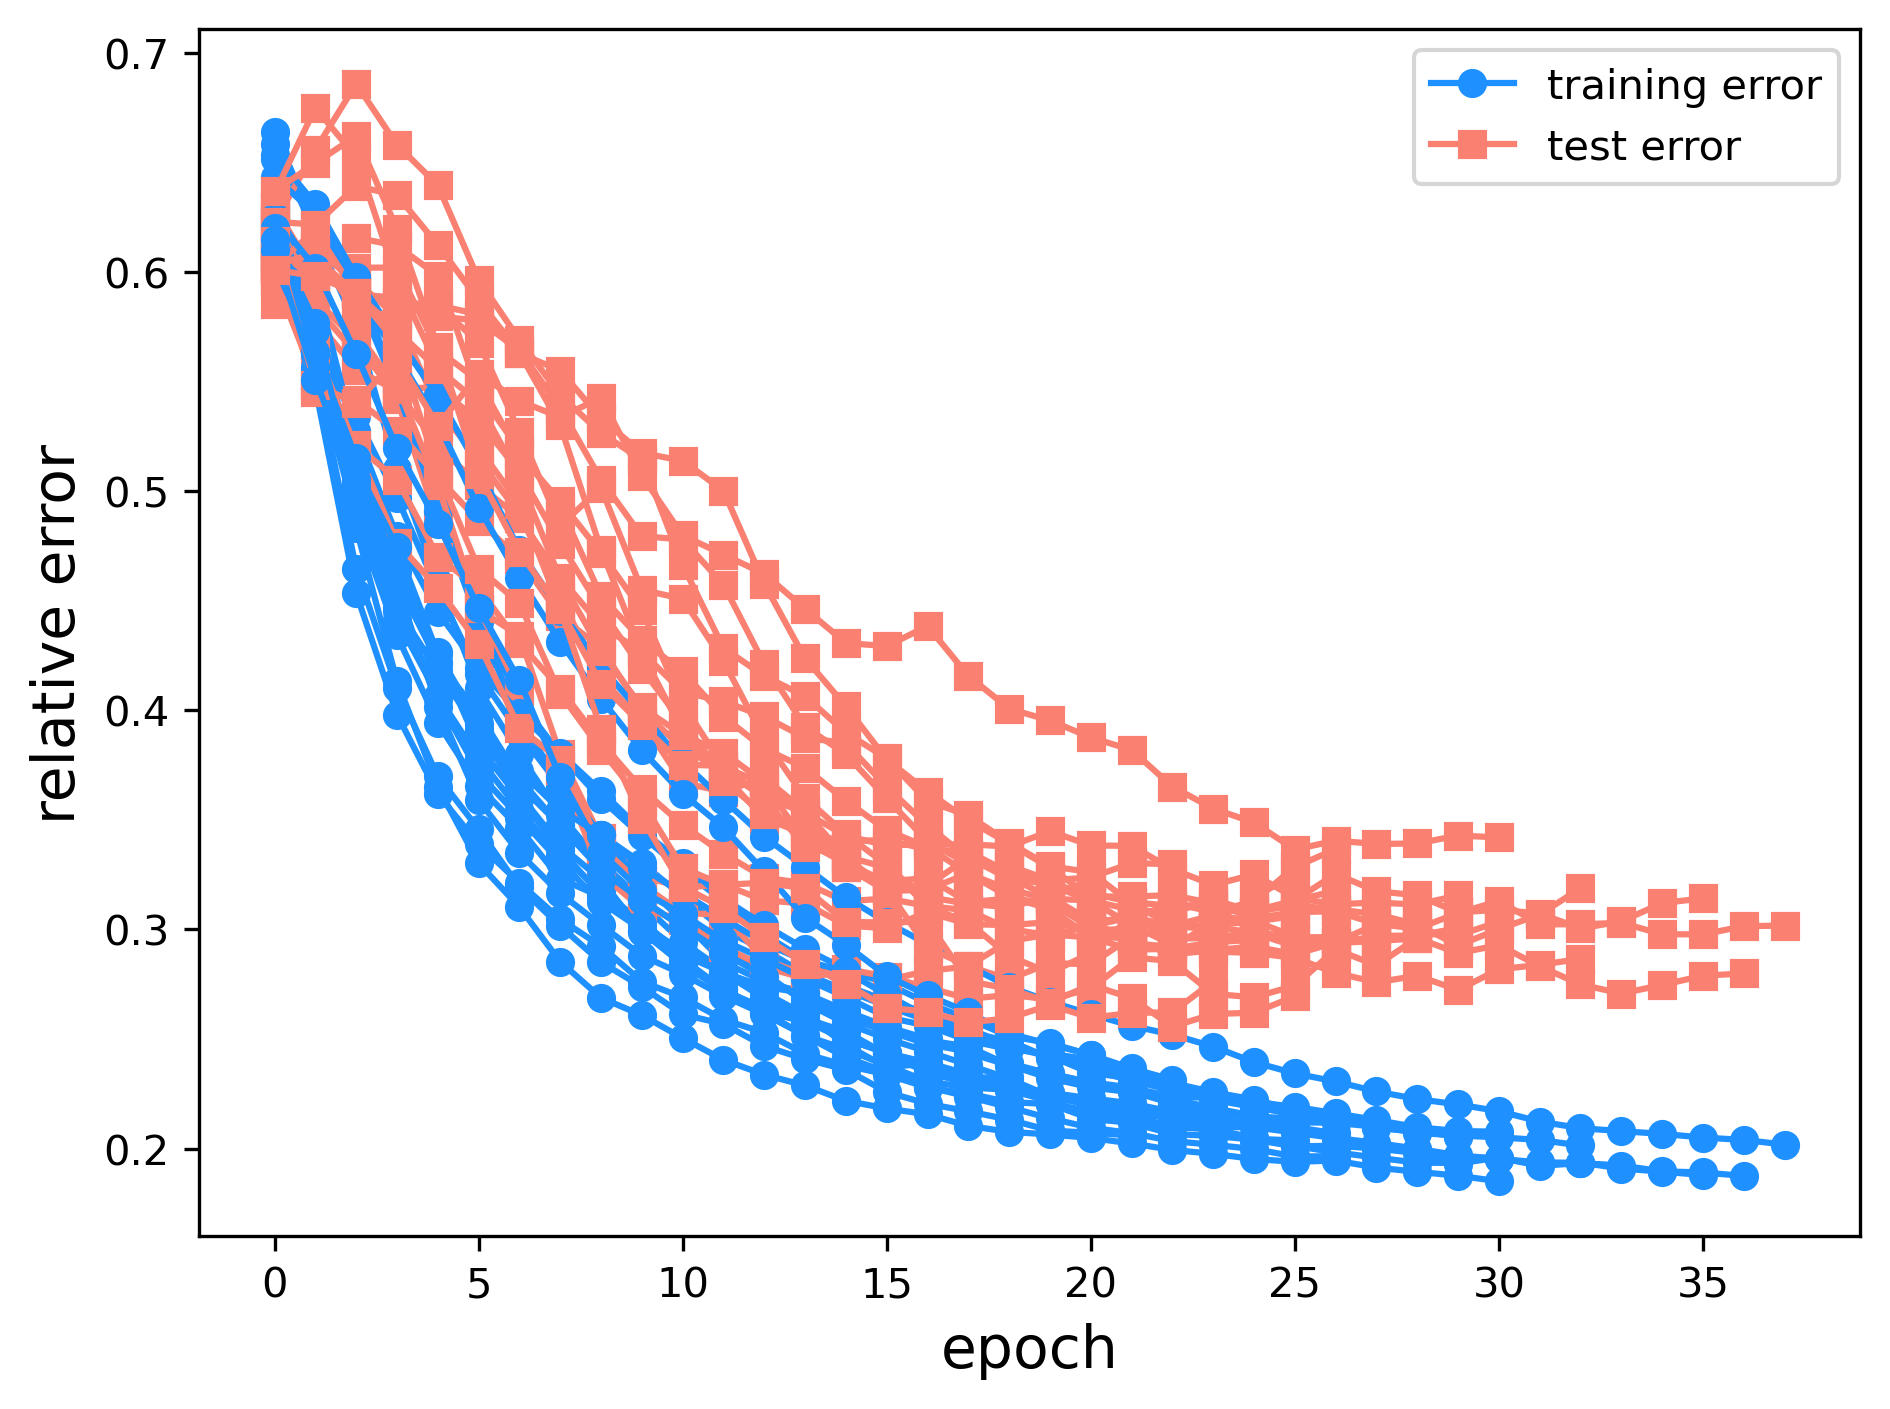

In [16]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


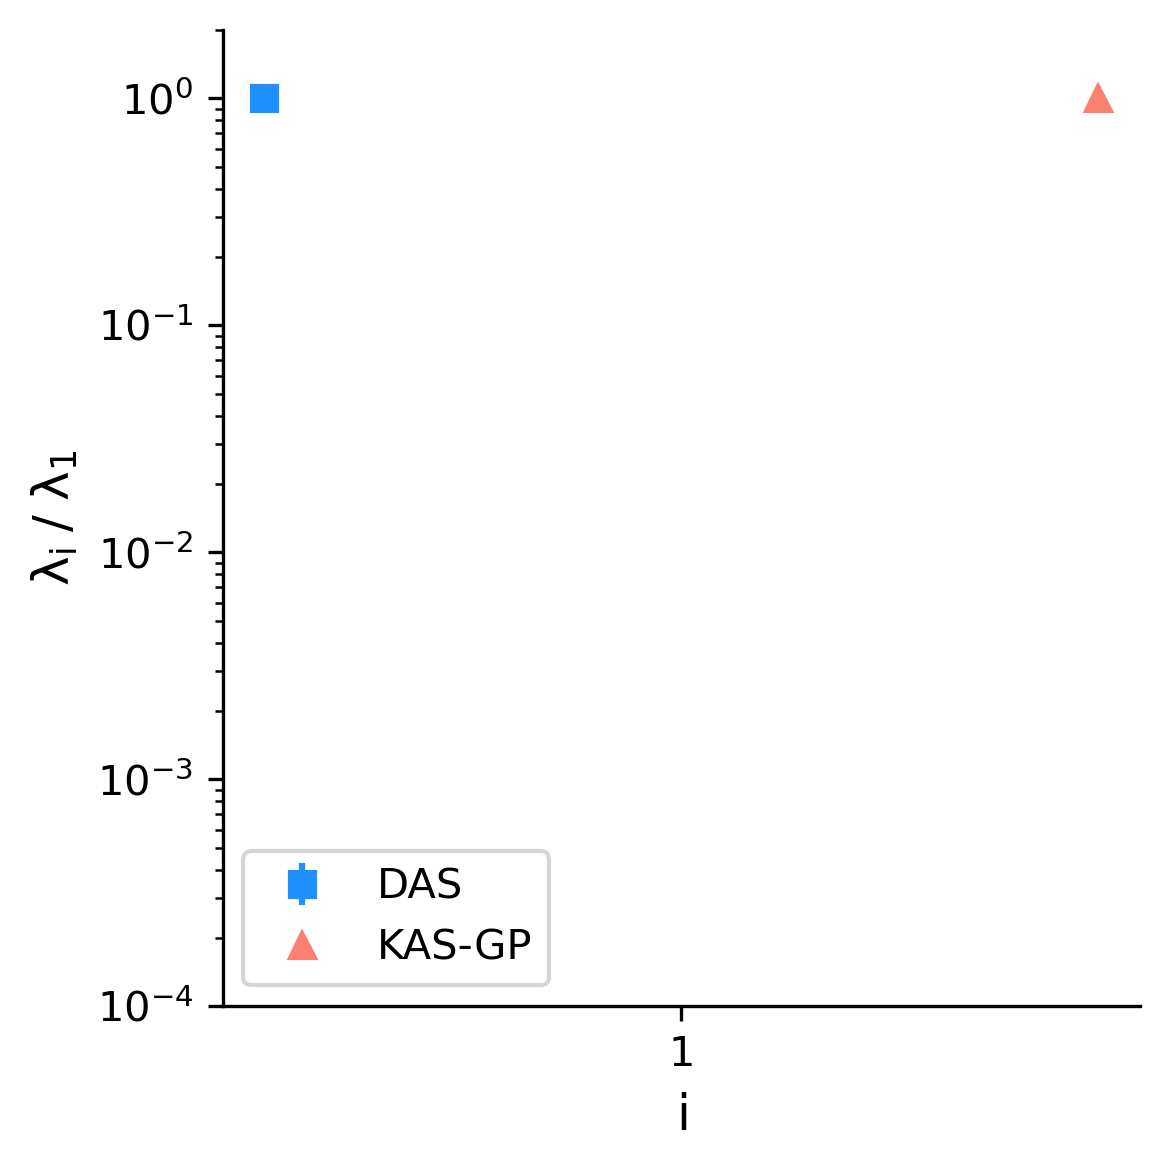

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_ties.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/ties_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the DAS surrogate a a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])


In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

### Recreate the active subspace plot

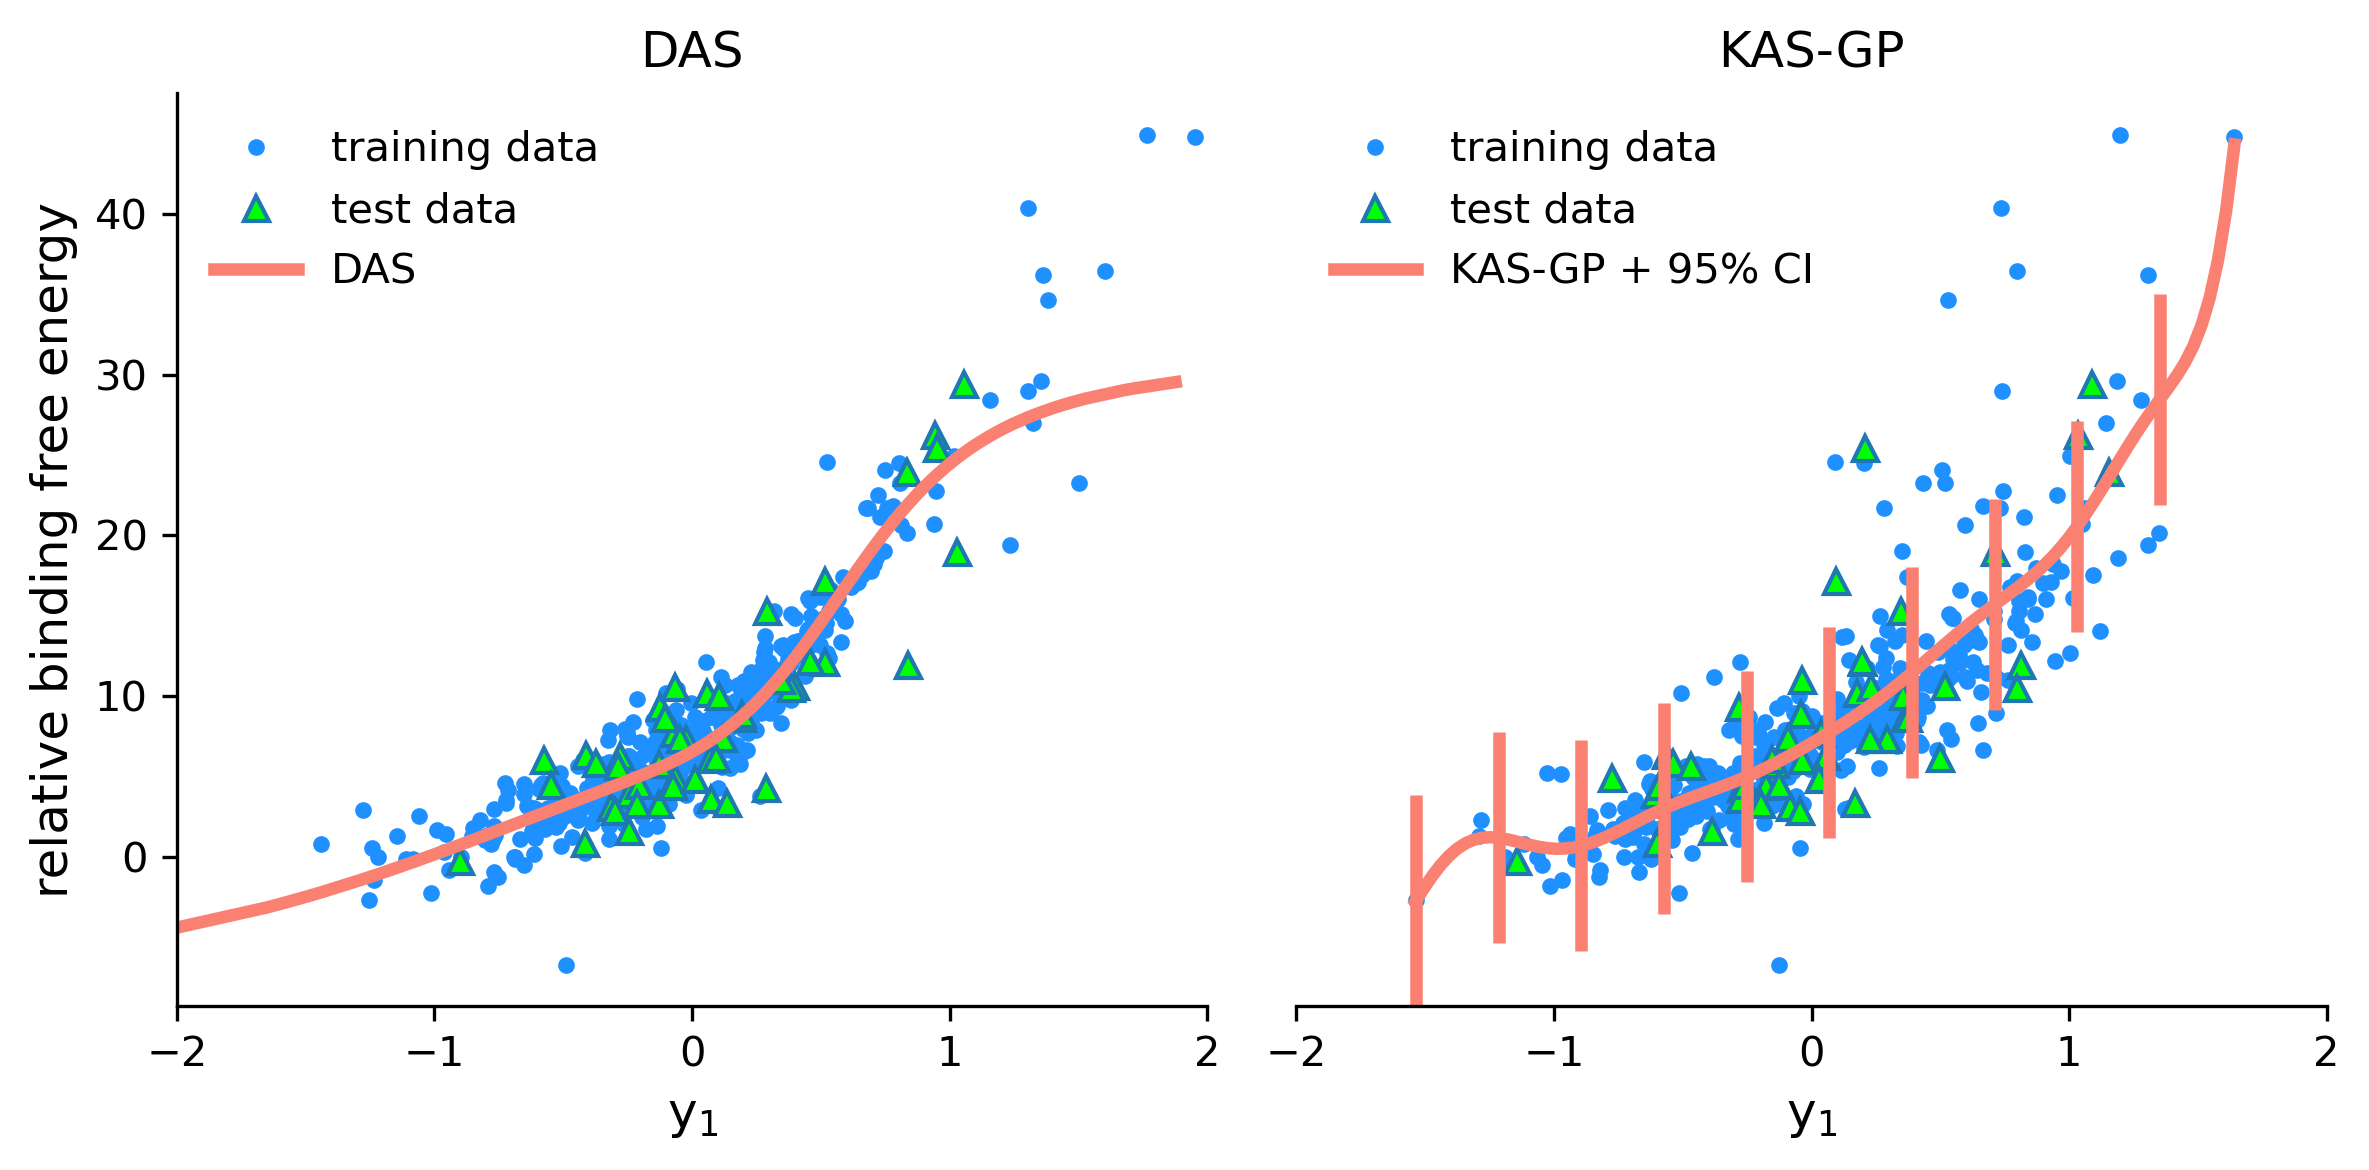

In [21]:
# QoI labels
lbl = {QoI: r'relative binding free energy'}

#########################
# plot active subspaces #
#########################
# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')    
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/ties_result.npy', allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/ties_surrogate_d%d.png' % (d, ))


### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_ties.csv')

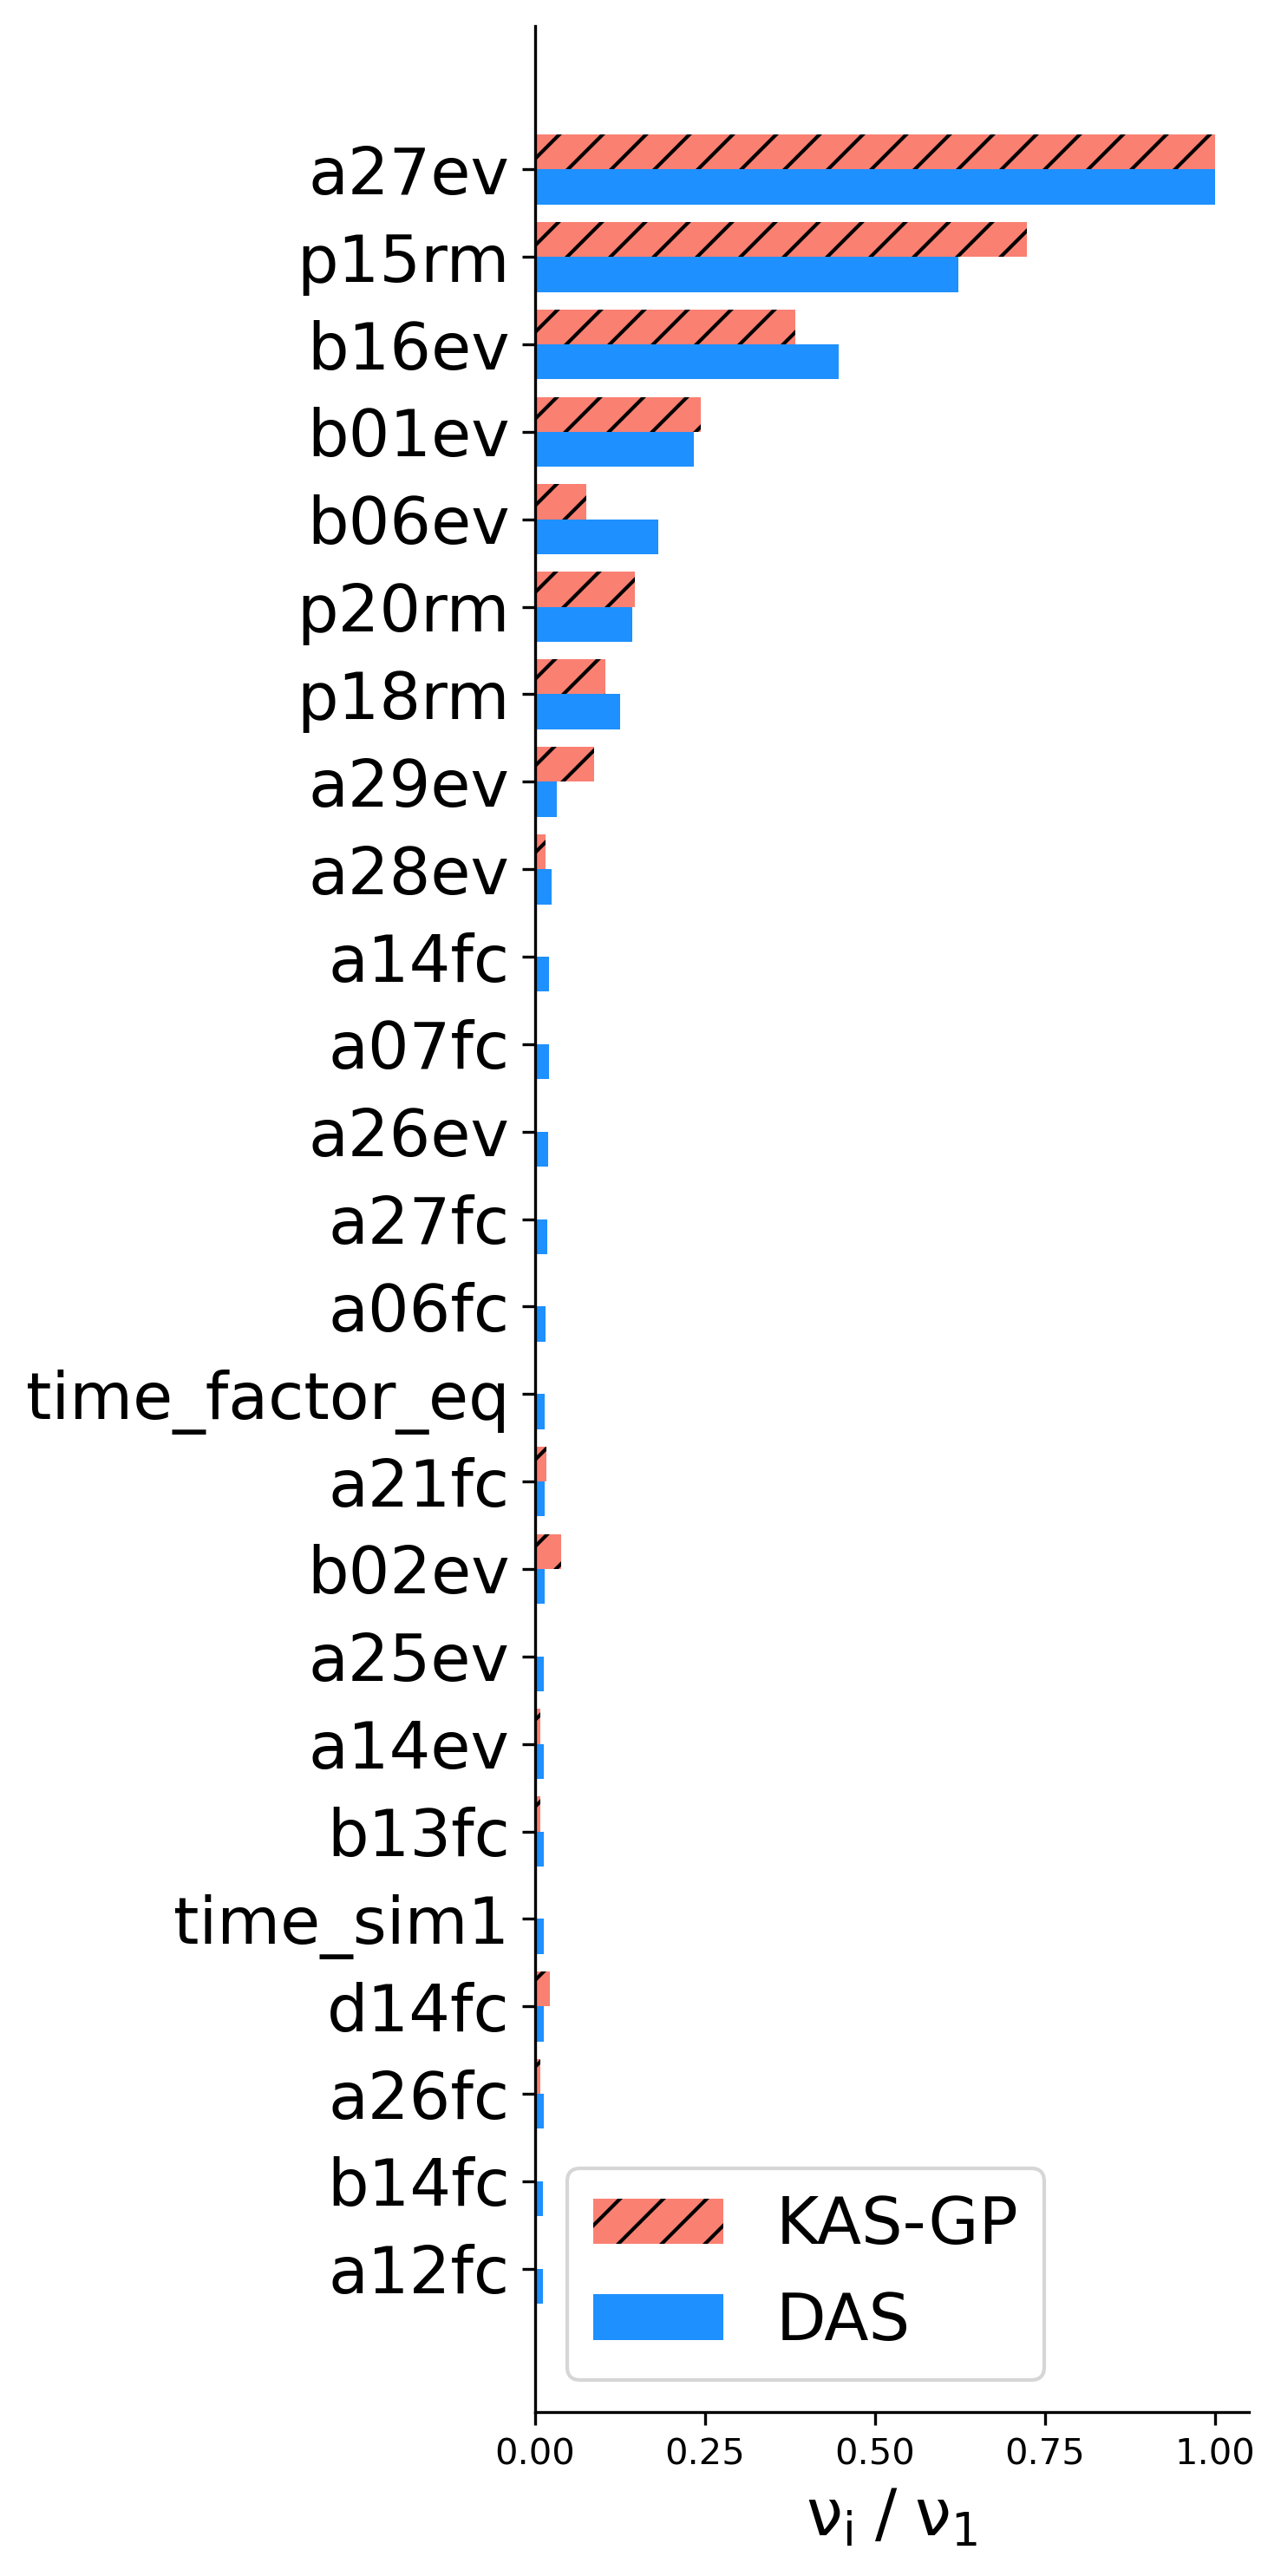

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


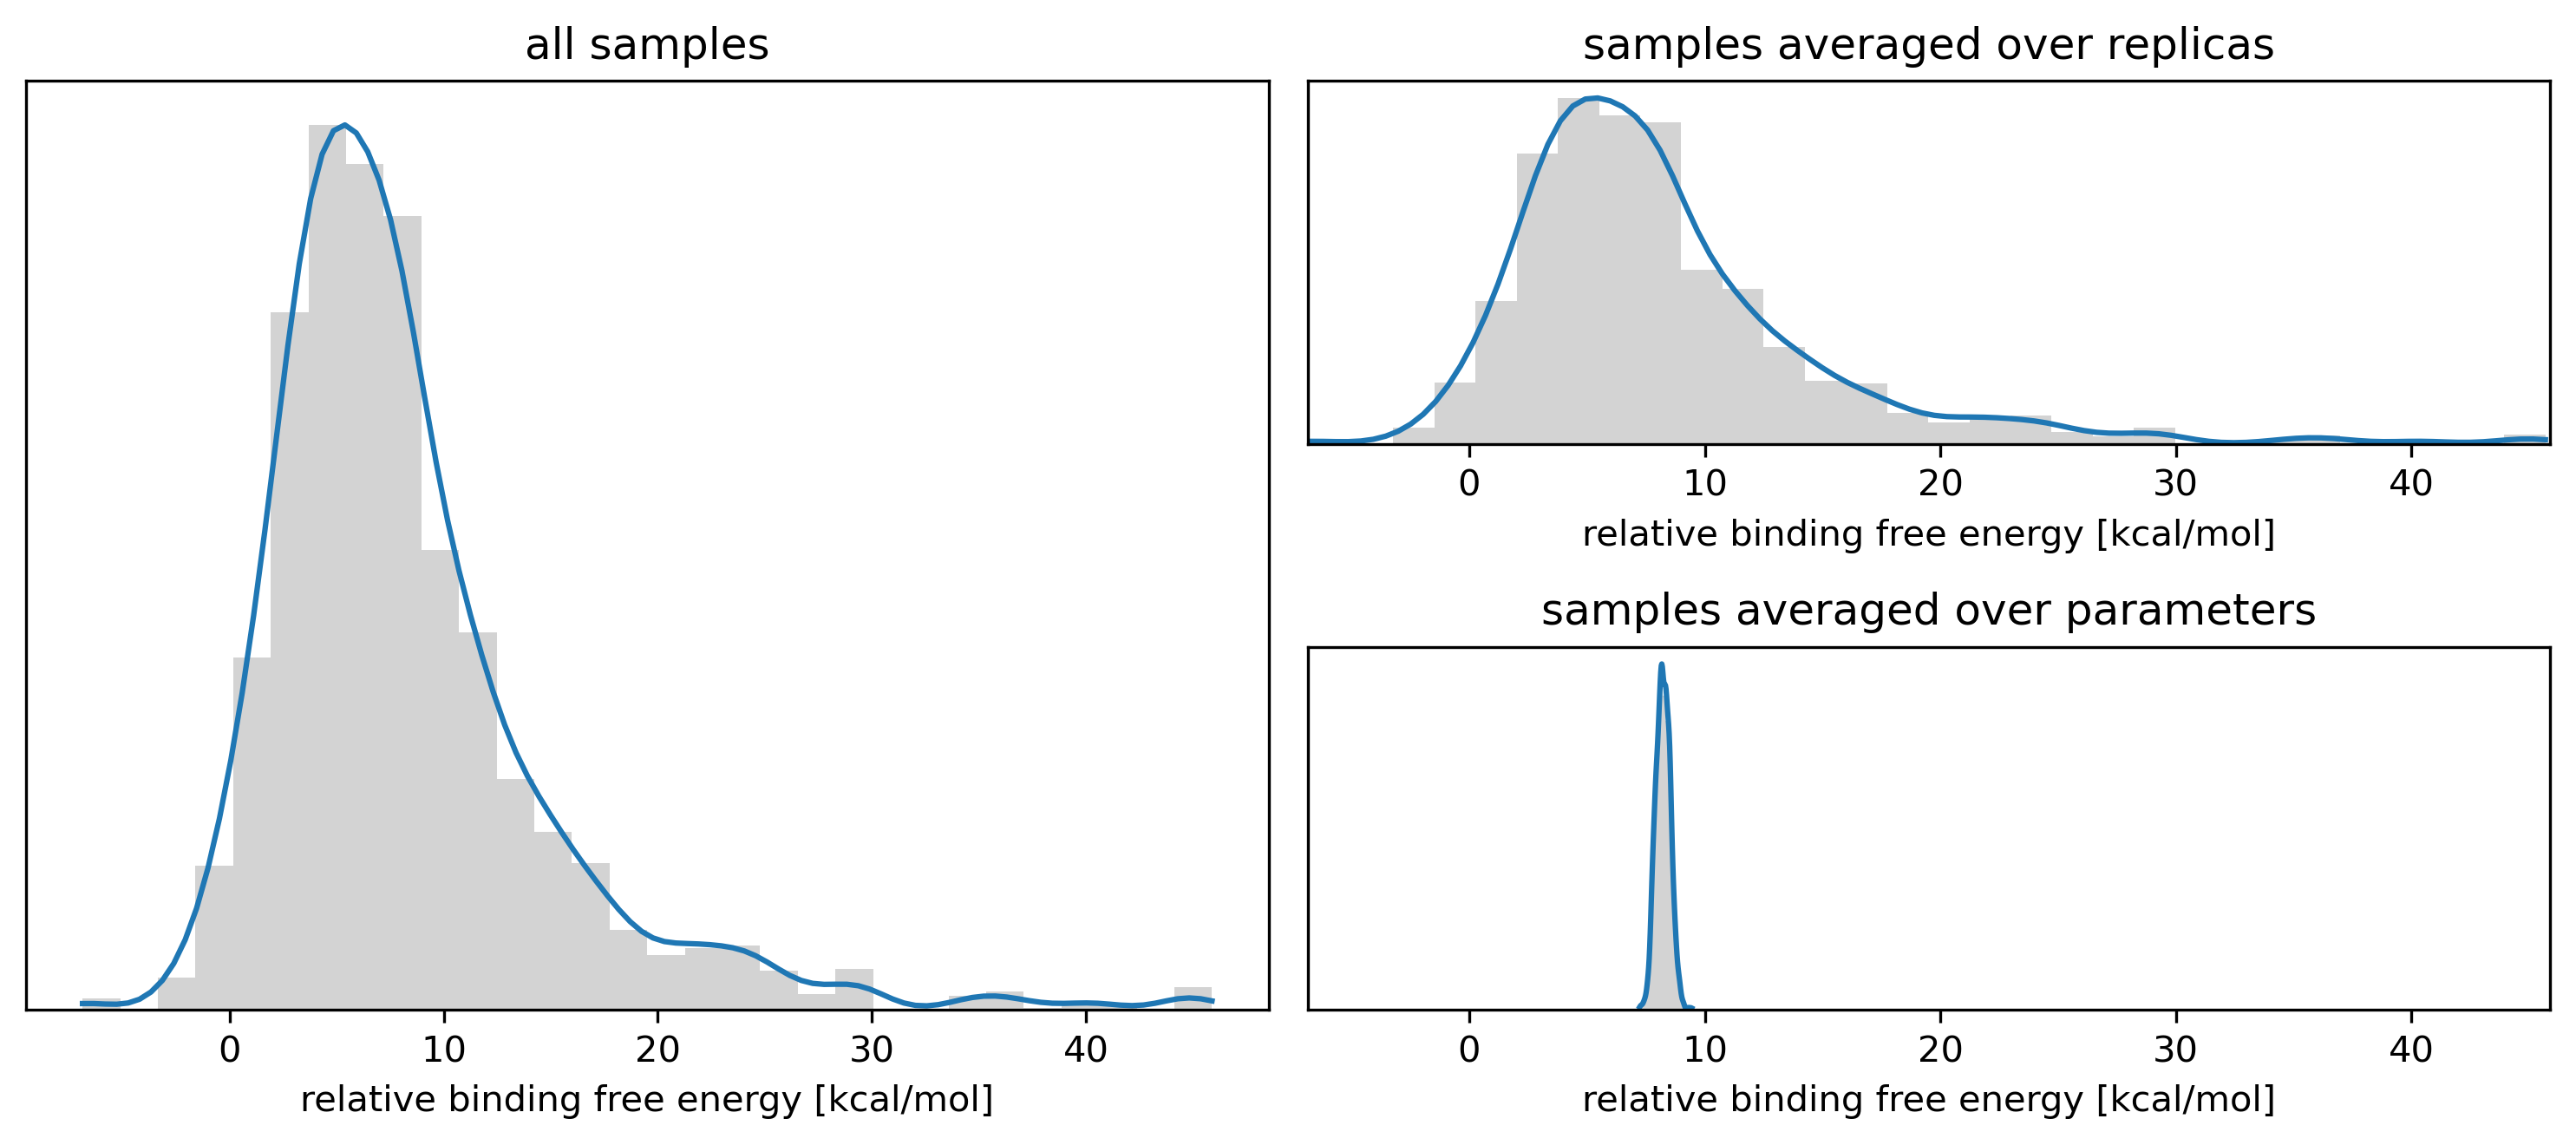

In [24]:
plot_dist(output, 'relative binding free energy [kcal/mol]')

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:11<00:00, 762.77it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2f (%.2f/%.2f)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2f (%.2f/%.2f)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.2f/%.2f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 8.23 (8.01/8.45)
Std dev: 6.70 (6.38/7.01)
Skew: 1.95 (1.77/2.11)
Kurt: 5.94 (4.92/6.88)
N_samples = 2440
